# <div align="center"> Data Science for Social Scientists  </div>
## <div align="center">Class 6 - Introduction to Prediction</div>
### <div align="center"> ECO 4199 </div>
### <div align="center"> 12 October 2021 </div>
### <div align="center"> Fabien Forge, (he/him)</div>

# Roadmap

- In the last two lectures we played with variable types and functions in order to find the function of X that will best predict Y
$$ Y = f(\mathbf{X}) + \varepsilon$$
- Regression and classification used tools that you were already familiar with (at least to some extent)
- But we only scratched the surface of what these functions may look like
- Today, we will keep using these tools with a different goal in mind
- This goal will require new tools...

# Assessing Model Accuracy 
- Why is it necessary to introduce so many different statistical learning approaches, rather than just a single best method? 
    - No one method dominates all others over all possible data sets. 
    - Hence it is an important task to decide for any given set of data which method produces the best results. 
- Selecting the best approach can be one of the most challenging parts of performing statistical learning in practice.

## Measuring the quality of fit

- We already discussed the R-squared which gives you information on the total variance in Y explained by your model
- But not all the functions we are going to use will give us an R-squared
    - for instance our maximum likelihood estimation of our logit model gave us a pseudo R-squared
- It turns out the way to measure the quality of fit depends on whether you are performing a regression or classification task

## Measuring the quality of fit in Regressions

- In the regression setting, the most commonly-used measure is the __mean squared error__ (MSE)
- You are already familiar with this measure from OLS but under another name

\begin{equation*}
\text{MSE} = \large \frac{1}{n} \sum_{i=1}^{n}(y_i - \hat{f}(x_i))^2
\end{equation*}

- $\hat{f}$ represents the prediction of our function for the data point $x_i$
- The better the prediction the smaller the distance between $y_i$ and $\hat{f}(x_i)$

In [22]:
# the basics
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Some reporting tools
from IPython.display import Markdown as md
import tabulate

#the stats packages
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Checking the versions of our packages
for p in [np,pd, matplotlib, sklearn,sns,statsmodels]:
    print(f"{p.__name__.capitalize()} uses the version {p.__version__}.")

Numpy uses the version 1.19.2.
Pandas uses the version 1.0.1.
Matplotlib uses the version 3.3.2.
Sklearn uses the version 0.23.2.
Seaborn uses the version 0.11.1.
Statsmodels uses the version 0.10.1.


## Mean square error in practice

- Let's reverse the order!
- Let's first define the function that relates y to X
- Specifically, say that the best predicting function should follow:
    $$y=f(x)=\cos(1.5\times \large\pi x)$$
- In the population there is some noise around the relationship so that:
$$ y_i = \cos(1.5\times \pi x_i) + \varepsilon_i$$

,x,y
0,0.020218,1.081908
1,0.071036,0.870276
2,0.087129,1.143862
3,0.118274,0.703221
4,0.143353,0.784947


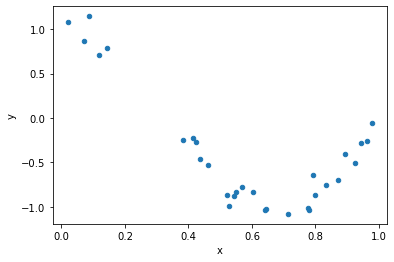

In [23]:
# Let's generate some fake data corresponding to our function
# True function is 1.5*pi
def true_fun(X):
    return np.cos(1.5 * np.pi * X)
# set seed to random numbers are always the same
np.random.seed(0)
# set the number of observations
n_samples = 30
# Generate X and y
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1
# store in a dataframe
df=pd.DataFrame({'x':X,'y':y})
display(df.head()) # show head
# scatter the relationship between X and y in our "population"
df.plot.scatter('x','y')
plt.show()

## Finding the right function
- Say that you did not plot the data before estimating your function (sad!)
- Being trained as an economist your best guess is that the relationship between X and y is... linear!
- Let's find the line of best fit and compute the MSE.
- We will use [Scikit-learn](https://scikit-learn.org/stable/) tools 

In [45]:
import numpy as np
X_test = np.linspace(0, 1, 100)
X_test

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

 Estimated slope: -1.6093117914612283


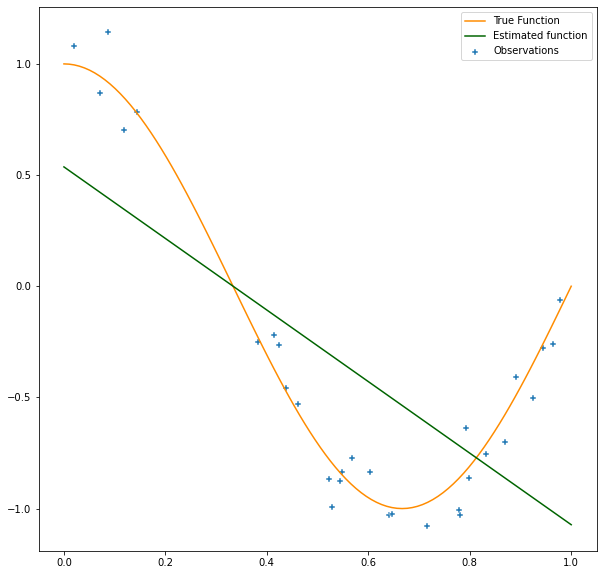

In [24]:
###### estimate the line of best fit and compare to the true function

### estimate the linear relationship between X and y
linear_regression = LinearRegression(fit_intercept=True) # initiate a linear regression class from scikit-learn LinearRegression
linear_regression.fit(df['x'].values.reshape(-1,1),y) # fit the data using this class; .reshape(-1, 1) allows to make is an (n,) vector

# Summary of the results
print(f" Estimated slope: {linear_regression.coef_[0]}")
def estimated_fun(x):
    return linear_regression.intercept_+ linear_regression.coef_[0]*x

# Create 100 equally spaced values for X between 0 and 1
X_test = np.linspace(0, 1, 100)
# predict values of y use X_test
y_pred=estimated_fun(X_test)

# initiate plot
fig, ax = plt.subplots(1,1, figsize=(10,10))
# plot the true function
sns.lineplot( x=X_test, y=true_fun(X_test),color='darkorange',label='True Function',ax=ax)
#plot the estimated (linear) relationship
sns.lineplot( x=X_test, y=y_pred,color='darkgreen',label='Estimated function',ax=ax)
# plot the scatter plot of the actual data
sns.scatterplot(x=X, y=y, label='Observations',ax=ax,marker="P")
plt.show()

## How good is this linear fit?
- Given the true function it was unlikely our line would give us a satisfying fit
- Let's see if we can improve on that
- but first what's our mean squared errors?

In [25]:
# Compare predicted to actual values for y
# create your own MSE function
def mse_fun(y,y_hat):
    """
    Take a y and a predicted y
    returns the MSE
    """
    diff_squared=np.square(y-y_hat)
    return np.mean(diff_squared)
# predict y using our estimated function, using our 30 observations
y_hat=estimated_fun(df['x'])   
# Print out our MSE
mse_degree1=mse_fun(y=y,y_hat=y_hat)
print(f"The MSE for the linear fit is {round(mse_degree1,3)}.")

The MSE for the linear fit is 0.226.


# Since we are talking about MSE
- By the way what do you expect the MSE for the true function is going to be?

In [26]:
# predict y, using the true function and our sample of 30 observations
y_pred_true_fun=true_fun(X)
# Compute the mean squared error of the true function using predicted values
mse_true_fun=mse_fun(y=y,y_hat=y_pred_true_fun)
print(f"The MSE for the linear fit is {round(mse_true_fun,3)}")

The MSE for the linear fit is 0.012


## Questions
- why is it not zero?
- how do you expect it to change with n?

# New function
- How about we introduce the square of our unique variable
- This will generate a non linear relationship between X and y, and as we know this relationship is not linear
- Before:
$y_i = \beta_0+\beta_1 x_i$
- After:
$y_i= \beta_0+\beta_1 x_i + \beta_2 x_i^2$
- This is called a __quadratic regression__

In [27]:
# Create the square of x
df['x2']=df['x']**2
# reorder columns
df=df[['y','x','x2']]
df.head()

,y,x,x2
0,1.081908,0.020218,0.000409
1,0.870276,0.071036,0.005046
2,1.143862,0.087129,0.007592
3,0.703221,0.118274,0.013989
4,0.784947,0.143353,0.020550


In [28]:
# iniate a linear regression class
quad_regression = LinearRegression()
# fit parameters on x and x-squared to best predict y
quad_regression.fit(df.iloc[:,df.columns.str.contains('x')],df['y'])
 
print("***Estimated parameters:***")
print('Intercept:',round(quad_regression.intercept_,2))
print('\u03B2\u0302\u2081:',round(quad_regression.coef_[0],2))
print('\u03B2\u0302\u2082:',round(quad_regression.coef_[1],2))

***Estimated parameters:***
Intercept: 1.54
β̂₁: -7.32
β̂₂: 5.56


## Question

If we have a non-linear relationship between X and y how come the function we use to estimate the relationship is called __linear__ regression?

## Predict
- You don't have to create your own function each time!
- Scitkit-learn got you covered!
- Let's now predict for all values of X between 0 and 1 (note how it differs from the 30 observations we fitted our data on!)

In [16]:
# pred y based on the X_test and X_test squared
y_pred_x2_test= quad_regression.predict(np.array([X_test,X_test**2]).T) # test set
 = quad_regression.predict(df[['x','x2']]) # use the results from quad_regression to predict y using our sample

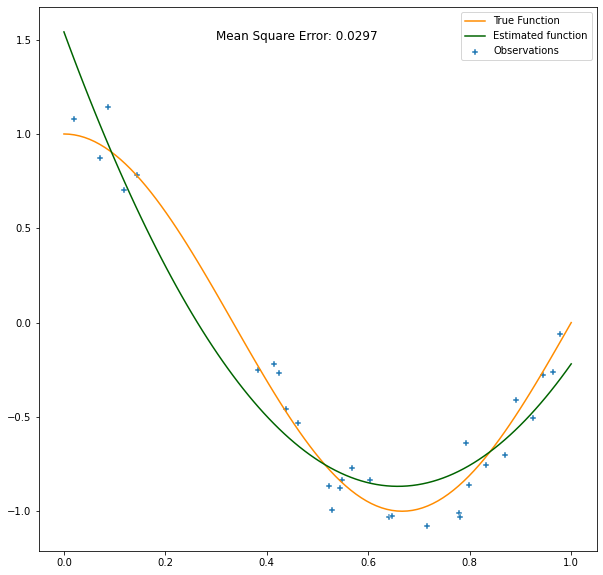

So adding a squared term improved our MSE from 0.2259 to 0.0297.
 This is much closer to the best MSE using the true function of 0.0125 

In [29]:
# initiate plot
fig, ax = plt.subplots(1,1, figsize=(10,10))
# plot the true function
sns.lineplot( x=X_test, y=true_fun(X_test),color='darkorange',label='True Function',ax=ax)
#plot the estimated (quadratic) relationship
sns.lineplot( x=X_test, y=y_pred_x2_test,color='darkgreen',label='Estimated function',ax=ax)
# plot the scatter plot of the actual data
mse_degree2=mse_fun(y=y,y_hat=y_hat_x2)
sns.scatterplot(x=X, y=y, label='Observations',ax=ax,marker="P")
ax.text(.3,1.5,f"Mean Square Error: {round(mse_degree2,4)}", fontsize=12)
plt.show()
md(f"So adding a squared term improved our MSE from {round(mse_degree1,4)} to {round(mse_degree2,4)}.\n This is much closer to the best MSE using the true function of {round(mse_true_fun,4)} ")


## Polynomial regression
- Clearly allowing for non-linearity went a long way in improving the fit
- What if we extended this function to higher and higher terms?
    - So far we used regressions of degree 1 and 2
    - We can extend this to any degree, this is called a polynomial regression
- A polynomial of degree n is given by:
$$f(x)=\beta_1 x^1 + \beta_2 x^2 + \beta_3 x^3 + ... +\beta_n x^n $$
$$ f(x)= \sum_1^n \beta_n x^n$$
- This yields the following model(s):
$$y_i= \beta_0 +\sum_1^n \beta_n x^n_i + \varepsilon_i$$

## Polynomials and MSE

- So what will happen to our MSE if we use higher and higher terms?
- Most likely we will allow for ever more __flexible functions__ of X to fit our data

- Want to try different polynomials?
- [Scitkit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) got you covered!
- In a loop let's try all polynomials from 1 to 15, save the corresponding MSE and see how it changes with degrees

In [30]:
MSE_list=[] # create empty list to store MSEs for each polynomial regression

polynomials=np.arange(1,16) # list of degrees
for n in polynomials:
    # prepocess the data
    polynomial_features =PolynomialFeatures(degree=n,include_bias=False) # initiate a class to get data of degree n without adding the constant term named bias in datascience. If you have read that far I have great feelings regarding your motivation. Case and point you are still reading even though there is no more information to be learned. That's it! In data science the interpect is called bias that's annoying but also now you know it and you can move on with your life. By the way, how's your life? This covid is really annoying innit? Oh look at me I talk British English now! Seriously, let's go back to work!  
    X_train=polynomial_features.fit_transform(df['x'].values.reshape(-1, 1)) # get data of degree n, we now have n columns from a single column X
    # regression
    reg = LinearRegression() # initiate the regression class
    reg.fit(X_train,y) # fit the data
    # predict on the train data
    y_hat= reg.predict(X_train)
    # get MSE for the fitted data using the train data
    mse=mse_fun(y=y,y_hat=y_hat)
    # append the result to the loop
    MSE_list.append(mse)

# put the results in dataframe
mse=pd.DataFrame({'Degree':polynomials, 'MSE':MSE_list})
mse.head()

,Degree,MSE
0,1,0.225892
1,2,0.029700
2,3,0.012483
3,4,0.011565
4,5,0.010973


- Let's now plot the relationship between polynomial degrees and our MSE score on our train data
- Recall that the best MSE, using the true function, was roughly 0.0125

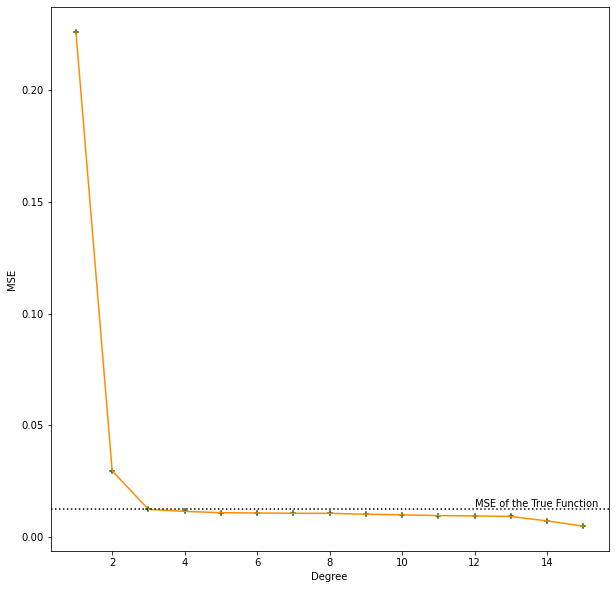

In [19]:
fig, ax=plt.subplots(1,1,figsize=(10,10))

sns.lineplot(data=mse, x='Degree',y='MSE',ax=ax, color='darkorange')
sns.scatterplot(data=mse, x='Degree',y='MSE',ax=ax, color='darkgreen',marker='P')
ax.axhline(y=mse_true_fun, color='k',linestyle=":")
ax.text(12,mse_true_fun+.001,"MSE of the True Function")

plt.show()

## Are higher degrees always better?
- It seems  higher and higher polynomials meant that we performed better than... the true function!
- Have we improved over the true function?
    - We did not
    - More importantly we should not
- Let's see why using our last estimated model (degree=15)

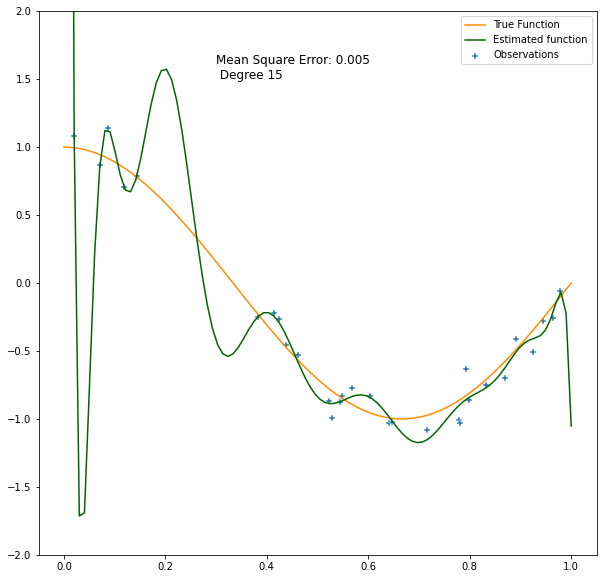

In [31]:
try: # make sure our last features are indeed of degree 15
    polynomial_features.degree==15
    X_test_n15=polynomial_features.fit_transform(X_test.reshape(-1,1)) # get data of degree n on a test data
    y_pred=reg.predict(X_test_n15) # predict on test data
    y_hat=reg.predict(X_train) # predict on train data
except:
    print(f"n is not 15 {polynomial_features}") # warn if try is wrong
# initiate plot
fig, ax = plt.subplots(1,1, figsize=(10,10))
# plot the true function
sns.lineplot( x=X_test, y=true_fun(X_test),color='darkorange',label='True Function',ax=ax)
#plot the estimated (quadratic) relationship
sns.lineplot( x=X_test, y=y_pred,color='darkgreen',label='Estimated function',ax=ax)
# plot the scatter plot of the actual data
sns.scatterplot(x=X, y=y, label='Observations',ax=ax,marker="P")
mse_degree15=round(mse_fun(y=y,y_hat=y_hat),4)
ax.text(.3,1.5,f"Mean Square Error: {mse_degree15}\n Degree {str(n)}", fontsize=12)
plt.ylim((-2, 2))

plt.show()

## Overfitting
- What we did here is called __overfitting__:
    - Given our dataset we fitted a function to pass very close to each observation $\{y_i,x_i\}$
- In our graph, the green line is very close to the points
- But when there is no points (observations) our prediction is very far from the true function
    - See for instance what you would predict for $x\approx 0.1$

## What are we using prediction for?

- We discussed in class 4 that sampling properties may impy that our estimates are somewhat far from the true population estimate
- Our issue here is slightly different. We are far because we found the function that maximizes __in sample prediction__
- Recall that our goal was instead to find the function $\hat{f}(x)$ that matches the true relationship between X and y 
- Why? Because we can then feed any x to  $\hat{f}(x)$, even one __out of sample__ and it should predict y closely
    - This is clearly not something our green line (polynomial of degree 15) is doing

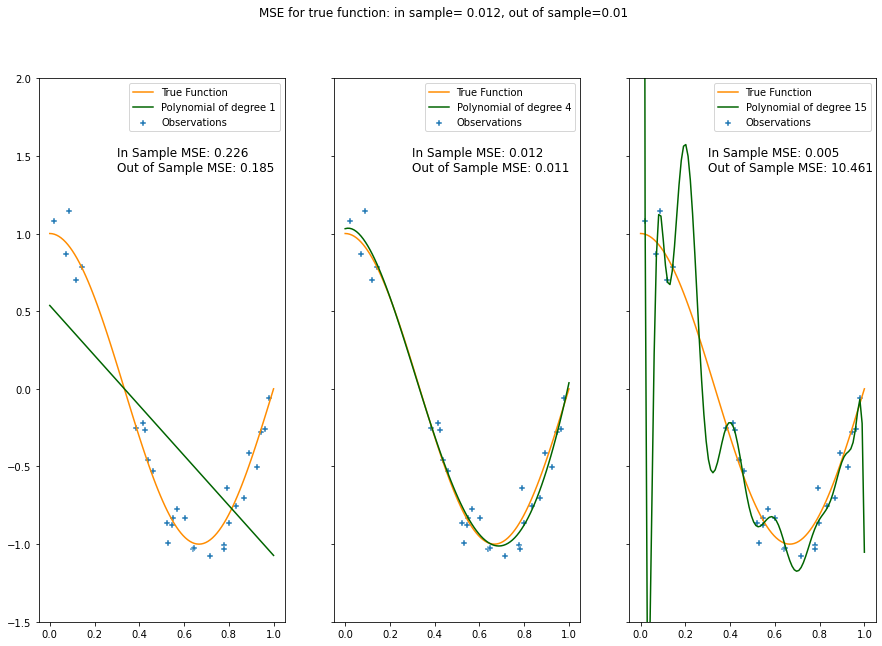

In [32]:
# initiate plot
fig, axes = plt.subplots(1,3, figsize=(15,10),sharey=True, sharex=True)

# create test target (out of sample)
X_test = np.linspace(0, 1, 100)
y_test = true_fun(X_test) + np.random.randn(len(X_test)) * 0.1

# Loop of three degrees
polynomials=[1,4,15] # list of degrees
for i,n in enumerate(polynomials): # i corresponds to the index (0, 1, 2); n takes the values in the polynomial list (1,4,15)
    
    # prepocess the data
    polynomial_features =PolynomialFeatures(degree=n,include_bias=False) # iniate a class to get data of degree n
    X_train=polynomial_features.fit_transform(df['x'].values.reshape(-1, 1)) # get data of degree n
    
    # regression
    reg = LinearRegression() # initiate the regression class
    reg.fit(X_train,y) # fit the data
    
    ### predict on the train and test data
    # in sample prediction
    y_hat_train= reg.predict(X_train) 
    # out of sample prediction
    X_test_pol=polynomial_features.fit_transform(X_test.reshape(-1,1))
    y_hat_test=reg.predict(X_test_pol)
    
    # get MSE for the fitted data using the train data
    mse_in_train=mse_fun(y=y,y_hat=y_hat_train)
    # get MSE for the fitted data using the test data
    mse_in_test=mse_fun(y=y_test,y_hat=y_hat_test)
    # get MSE for the true function using the train data
    mse_in_train_true_fun=mse_fun(y=y,y_hat=true_fun(X))
    # get MSE for the true function using the test data
    mse_in_test_true_fun=mse_fun(y=y_test,y_hat=true_fun(X_test))
    

    # plot the true function
    sns.lineplot( x=X_test, y=true_fun(X_test),color='darkorange',label='True Function',ax=axes[i])
    # plot the scatter plot of the actual data
    sns.scatterplot(x=X, y=y, label='Observations',marker="P",ax=axes[i])
    #plot the estimated function
    sns.lineplot( x=X_test, y=y_hat_test,color='darkgreen',label=f'Polynomial of degree {n}',ax=axes[i])
    # Display MSEs
    axes[i].text(.3,1.5,f"In Sample MSE: {round(mse_in_train,3)}", fontsize=12)
    axes[i].text(.3,1.4,f"Out of Sample MSE: {round(mse_in_test,3)}", fontsize=12)


plt.ylim((-1.5, 2))
fig.suptitle(f"MSE for true function: in sample= {round(mse_in_train_true_fun,3)}, out of sample={round(mse_in_test_true_fun,3)}")
plt.show()

## Auto.csv

- Let's use the <span style="color:orange;">Auto dataset</span> from [ISLR](https://www.statlearning.com/)
- Using this data we want to predict fuel consumption (miles per gallon _mpg_) based on _horsepower_
- This time we do not know what is the true function
    - But increasing marginal cost of power may apply here...
- So let's try a few polynomials in the relationship between these two variables

In [35]:
df=pd.read_csv("Auto.csv") # load data
df['horsepower']=pd.to_numeric(df['horsepower'].replace("?",np.nan)) # data cleaning
df.dropna(subset=['horsepower','mpg'],inplace=True)
df.reset_index(inplace=True)
display(df.info()) # display info
df.head().append(df.tail()) # show head and tail

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         392 non-null    int64  
 1   mpg           392 non-null    float64
 2   cylinders     392 non-null    int64  
 3   displacement  392 non-null    float64
 4   horsepower    392 non-null    float64
 5   weight        392 non-null    int64  
 6   acceleration  392 non-null    float64
 7   year          392 non-null    int64  
 8   origin        392 non-null    int64  
 9   name          392 non-null    object 
dtypes: float64(4), int64(5), object(1)
memory usage: 30.8+ KB


None

,index,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino
387,392,27.0,4,140.0,86.0,2790,15.6,82,1,ford mustang gl
388,393,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup
389,394,32.0,4,135.0,84.0,2295,11.6,82,1,dodge rampage
390,395,28.0,4,120.0,79.0,2625,18.6,82,1,ford ranger
391,396,31.0,4,119.0,82.0,2720,19.4,82,1,chevy s-10


## Train vs Test
- We now have two distinct measure of fit
- The in sample MSE is the one you are used to and consists in finding the best fit given the available data
- The out of sample MSE is new and as important, if not more, as the in sample MSE
- But recall that we won't always be so lucky that we already know the population function
    - That is we won't be able to generate new datasets to measure out of sample MSE like we just did
    - How to measure out of sample MSE if you have limited, although potentially large, dataset?
- Let's use a real example

In [36]:
# Regress Sales on a constant term and TV
results = smf.ols('mpg ~ horsepower', data=df).fit() # degree 1
# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Fri, 26 Feb 2021   Prob (F-statistic):           7.03e-81
Time:                        10:22:04   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.0

In [37]:
models=['mpg ~ horsepower', 'mpg ~ horsepower + np.square(horsepower)','mpg ~ horsepower + np.square(horsepower)+np.power(horsepower,3)']
n=len(models)

R2=np.full(n, np.nan); degrees=np.full(n, np.nan)
beta_1=np.full(n, np.nan) ; beta_2=np.full(n, np.nan) ; beta_3=np.full(n, np.nan) 
p_1=np.full(n, np.nan) ; p_2=np.full(n, np.nan) ; p_3=np.full(n, np.nan)
for i,m in enumerate(models):
    results = smf.ols(m, data=df).fit()
    #print(results.summary()) # uncomment if you want details
    
    R2[i]=results.rsquared ; degrees[i]=i+1
    beta_1[i]=results.params['horsepower'] ; p_1[i]=results.pvalues['horsepower']
    if i>0:
        beta_2[i]=results.params['np.square(horsepower)'] ; p_2[i]=results.pvalues['np.square(horsepower)']
        if i>1:
            beta_3[i]=results.params['np.power(horsepower, 3)'] ; p_3[i]=results.pvalues['np.power(horsepower, 3)']
        
res=pd.DataFrame({'Degree':degrees, 
                  r'$R^2$': R2,
                  r'$\hat{\beta}_1$':beta_1, r'p-value $\hat{\beta}_1$':p_1,
                  r'$\hat{\beta}_2$':beta_2, r'p-value $\hat{\beta}_2$':p_2,
                  r'$\hat{\beta}_3$':beta_3, r'p-value $\hat{\beta}_3$':p_3})

res['Degree']=res['Degree'].astype(np.int8)
res

,Degree,$R^2$,$\hat{\beta}_1$,p-value $\hat{\beta}_1$,$\hat{\beta}_2$,p-value $\hat{\beta}_2$,$\hat{\beta}_3$,p-value $\hat{\beta}_3$
0,1,0.605948,-0.157845,7.031989e-81,NaN,NaN,NaN,NaN
1,2,0.687559,-0.466190,2.289429e-40,0.001231,2.196340e-21,NaN,NaN
2,3,0.688214,-0.568850,2.025851e-06,0.002079,2.888499e-02,-0.000002,0.367297


## Do we need higher-order polynomials?
- Is higher better?
    - Here we do not even need out of sample MSE since:
        - the p-value attached to the cubic term suggests it is not significant
        - the value of the parameter is very small
        - the $R^2$ is left unchanged
- We may still want to decide based on out of sample measures of the MSE

## The Validation Set Approach

- A simple way to know about the out of sample performance of our model is to split the dataset in two:
    -  __training set__ 
    -__validation set__ or hold-out set 
    validation set or hold-out set.
- You then compute the MSE on the validation set

- Here again we will use [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- We will split the data between train and test sets, 50/50

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df['horsepower'], df['mpg'], test_size=.5, random_state=1706)
    
print(f"Shape of X_train: {X_train.shape}") ; print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}") ; print(f"Shape of y_test: {y_test.shape}")

polynomials=[1,2,3]
for i,n in enumerate(polynomials): # i corresponds to the index (0, 1, 2); n takes the values in the polynomial list (1,2,3)
    # prepocess the data
    polynomial_features =PolynomialFeatures(degree=n,include_bias=False) # iniate a class to get data of degree n
    X_train_new=polynomial_features.fit_transform(X_train.values.reshape(-1, 1)) # get data of degree n
    X_test_new=polynomial_features.fit_transform(X_test.values.reshape(-1, 1)) # get data of degree n

    
    # regression
    reg = LinearRegression() # initiate the regression class
    reg.fit(X_train_new,y_train) # fit the data
    
    # Out of Sample MSE:
    mse=mean_squared_error(y_test, reg.predict(X_test_new))
    print(f"Polynomial regression of degree {n} has an out of sample MSE score of {mse}")
    


Shape of X_train: (196,)
Shape of X_test: (196,)
Shape of y_train: (196,)
Shape of y_test: (196,)
Polynomial regression of degree 1 has an out of sample MSE score of 28.05545734384403
Polynomial regression of degree 2 has an out of sample MSE score of 22.37041827786019
Polynomial regression of degree 3 has an out of sample MSE score of 22.55001085672741


## Sampling properties
- Remember when talked sampling properties of OLS?
- The smaller the sample size the less precise the estimate
    - What if our 50/50 split happens to train our data on a fairly unrepresentative sample?
    - let's confirm this using different 50/50 splits for our models

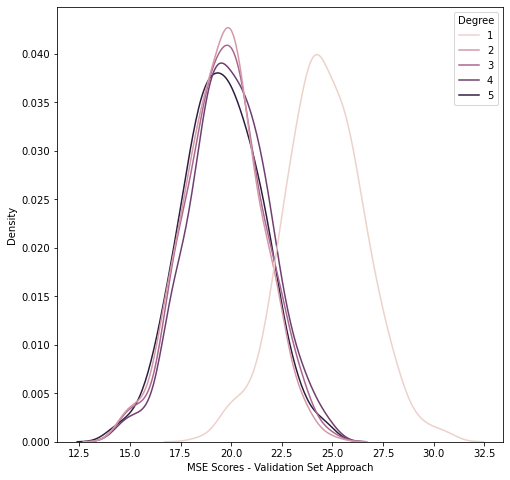

In [40]:
polynomials=[1,2,3,4,5]
DFs=[] # empty list of dataframes
for n, p in enumerate(polynomials):
    MSEs=[] # empty list of MSE scores
    for i in range(len(df)):
        # split the data (a different sample with each iteration)
        X_train, X_test, y_train, y_test = train_test_split(df['horsepower'], df['mpg'], test_size=.5, random_state=i)

        # prepocess the data
        polynomial_features =PolynomialFeatures(degree=p,include_bias=False) # iniate a class to get data of degree n
        X_train_new=polynomial_features.fit_transform(X_train.values.reshape(-1, 1)) # get data of degree n
        X_test_new=polynomial_features.fit_transform(X_test.values.reshape(-1, 1)) # get data of degree n

        # regression
        reg = LinearRegression() # initiate the regression class
        reg.fit(X_train_new,y_train) # fit the data

        # Out of Sample MSE:
        mse=mean_squared_error(y_test, reg.predict(X_test_new))
        MSEs.append(mse)
    # store all MSEs for degree p in a dataframe and append to list of dataframes    
    DFs.append(pd.DataFrame({'Degree':p, 'MSE':MSEs}))

dd=pd.concat(DFs)    
# show the distribution of MSEs
fig, ax = plt.subplots(1,1, figsize=(8,8))

sns.kdeplot(data=dd, x='MSE', ax=ax, hue='Degree')
ax.set_xlabel("MSE Scores - Validation Set Approach")
plt.show()

##  Leave-one-out cross-validation (LOOCV) 
- leave-one out cross validation is closely related to the validation set approach but it attempts to address that method’s drawbacks.
- Like the validation set approach, _LOOCV_ involves splitting the set of observations into two parts. 
    - However, instead of creating two subsets of comparable size 
    - a single observation $(x_1, y_1)$ is used for the validation set
    - the remaining observations $\{(x_2, y_2), . . . , (x_n, y_n)\}$ make up the training set
- The statistical learning method is fit on the n − 1 training observations, and a prediction $\hat{y}_1$ is made for the excluded observation, using its value x1

##  Leave-one-out cross-validation (LOOCV), continued
- Since $(x_1, y_1)$ was not used in the fitting process
    - $MSE_{1}$ = $(y_1-\hat{y}_1)^2$
- This provides an approximately __unbiased estimate for the test error__.
- But even though MSE is unbiased for the test error, it is a poor estimate because it is highly variable, since it is based upon a single observation $(x_1, y_1)$.
- We can repeat the procedure by selecting (x2, y2) and so on:
    -     - $MSE_{(n)}$ = $(y_n-\hat{y}_n)^2$
- The LOOCV estimate for the test MSE is the average of these n test error estimates:
    - $MSE_{(LOOCV)} = \frac{1}{n} \sum_{i=1}^n MSE_{i}$

,Mean_MSE
Degree,
1,24.231514
2,19.248213
3,19.334984
4,19.424430
5,19.033213


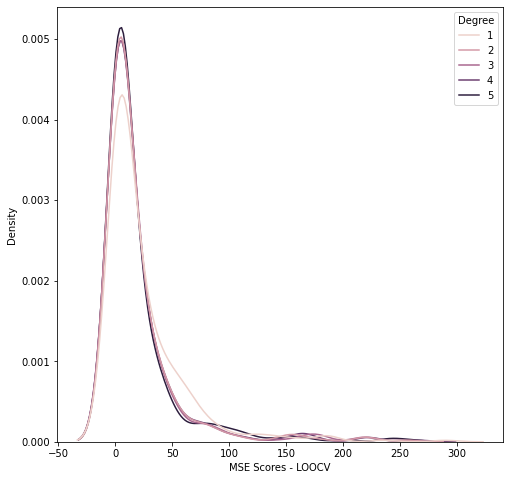

CPU times: user 13.1 s, sys: 466 ms, total: 13.6 s
Wall time: 8.9 s


In [41]:
%%time
polynomials=[1,2,3,4,5]
DFs=[] # empty list of dataframes
for n, p in enumerate(polynomials):
    MSEs=[] # empty list of MSE scores
    for i in range(len(df)):
        # split the data (a different sample with each iteration)
        X_train, X_test, y_train, y_test = df.loc[df.index!=i,'horsepower'],df.loc[df.index==i,'horsepower'] , df.loc[df.index!=i,'mpg'],df.loc[df.index==i,'mpg'].values[0]

        # prepocess the data
        polynomial_features =PolynomialFeatures(degree=p,include_bias=False) # iniate a class to get data of degree n
        X_train_new=polynomial_features.fit_transform(X_train.values.reshape(-1, 1)) # get data of degree n
        X_test_new=polynomial_features.fit_transform(np.array(X_test).reshape(-1, 1)) # get data of degree n

        # regression
        reg = LinearRegression() # initiate the regression class
        reg.fit(X_train_new,y_train) # fit the data

        # Out of Sample MSE:
        mse=np.square(y_test-reg.predict(X_test_new)[0]) # Out of Sample MSE
        MSEs.append(mse)
    # store all MSEs for degree p in a dataframe and append to list of dataframes    
    DFs.append(pd.DataFrame({'Degree':p, 'MSE':MSEs}))

dd=pd.concat(DFs)    
display(dd.groupby('Degree').agg(Mean_MSE=('MSE','mean')))
# show the distribution of MSEs
fig, ax = plt.subplots(1,1, figsize=(8,8))
sns.kdeplot(data=dd, x='MSE', ax=ax, hue='Degree')
ax.set_xlabel("MSE Scores - LOOCV")
plt.show()

## k-Fold Cross-Validation
- An alternative to LOOCV is k-fold cross validation. 
- This approach involves randomly dividing the set of observations into k groups, or __folds__, of approximately equal size. 
- The first fold is treated as a validation set, and the method is fit on the remaining k − 1 folds. 
- The mean squared error, $MSE_1$, is then computed on the observations in the held-out fold. 
- This procedure is repeated k times; each time, a different group of observations is treated as a validation set.
- This process results in k estimates of the test error, $MSE_1$,$MSE_2$, . . . ,$MSE_k$. 
- The k-fold CV estimate is computed by averaging these values:
    - $MSE_{(k-fold CV)} = \frac{1}{k} \sum_{i=1}^k MSE_{i}$

# k-fold Cross-Validation, continued
- Note that LOOCV is a special case of k-fold CV in which k is set to equal n. 
- Standard practices consist in using k = 5 or k = 10. 
- What is the advantage of using k = 5 or k = 10 rather than k = n? 
    - Computation time which will increase with dataset sizes. 
    - LOOCV requires fitting the statistical learning method n times. 
        - This has the potential to be computationally expensive 
    - Performing 10-fold CV requires fitting the learning procedure only ten times

In [43]:
%%time
X = df['horsepower'].values
y = df['mpg'].values
polynomials=[1,2,3,4,5]
kDFs=[]
for k in [5,10]:
    DFs=[]
    # Split in k folds
    kf = KFold(n_splits=k, random_state=1706, shuffle=True)
    for p in polynomials:
        MSEs=[] # empty list of MSE scores
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # prepocess the data
            polynomial_features =PolynomialFeatures(degree=p,include_bias=False) # iniate a class to get data of degree n
            X_train_new=polynomial_features.fit_transform(X_train.reshape(-1, 1)) # get data of degree n
            X_test_new=polynomial_features.fit_transform(X_test.reshape(-1, 1)) # get data of degree n

            # regression
            reg = LinearRegression() # initiate the regression class
            reg.fit(X_train_new,y_train) # fit the data

            # Out of Sample MSE:
            mse=mean_squared_error(y_test, reg.predict(X_test_new))
            MSEs.append(mse)
            # store all MSEs for degree p in a dataframe and append to list of dataframes    
        DFs.append(pd.DataFrame({'Degree':p, 'k-fold':k,'MSE':MSEs}))

    dd=pd.concat(DFs) 
    kDFs.append(dd)

dd=pd.concat(kDFs)
mse_change=dd.groupby(['Degree','k-fold']).agg(Mean_MSE=('MSE','mean'))


CPU times: user 366 ms, sys: 24.1 ms, total: 390 ms
Wall time: 258 ms


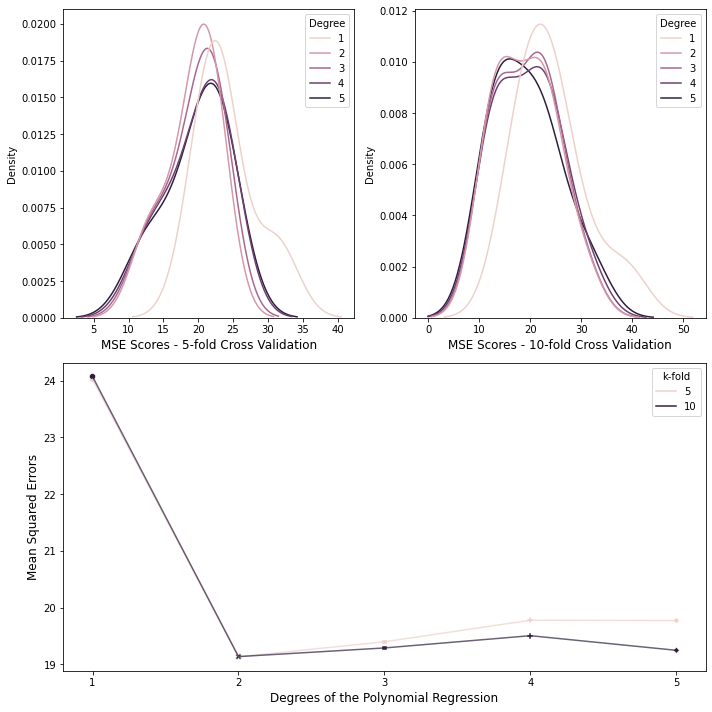

In [44]:
# show the distribution of MSEs
fig, axes = plt.subplots(2,2, figsize=(10,10))
sns.kdeplot(data=dd.loc[dd['k-fold']==5], x='MSE', ax=axes[0,0], hue='Degree')
axes[0,0].set_xlabel("MSE Scores - 5-fold Cross Validation",fontsize=12)
sns.kdeplot(data=dd.loc[dd['k-fold']==10], x='MSE', ax=axes[0,1], hue='Degree')
axes[0,1].set_xlabel("MSE Scores - 10-fold Cross Validation",fontsize=12)

gs = axes[1, 1].get_gridspec()
for ax in axes[1, :]:
    ax.remove()
axbottom = fig.add_subplot(gs[1, :])
sns.lineplot(data=mse_change.reset_index(),x='Degree', y='Mean_MSE',hue='k-fold',alpha=.7, ax=axbottom)
sns.scatterplot(data=mse_change.reset_index(),x='Degree', y='Mean_MSE',hue='k-fold',style='Degree', ax=axbottom,legend=False)
axbottom.set_xlabel("Degrees of the Polynomial Regression",fontsize=12)
axbottom.set_ylabel("Mean Squared Errors",fontsize=12)
axbottom.set_xticks(np.arange(1,len(polynomials)+1))
fig.tight_layout()

plt.show()

## Why do we use resampling methods?
- Cross Validation is one of the several __resampling methods__ one can use to learn about predictive performance 
- Do we really care about the test MSE value we get from CV?
    - If you want to know the performance of a given statistical model, yes
        - e.g. Given my model how wrong should I expect my predictions to be "on average"?
- Sometimes you may only be interested in the location of the minimum point in the test MSE
    - If you want to compare perfomance of different models 
        - Like we did today
    - The actual value of the test MSE is not important
     - What matters is which models performs best
         - within the same method using different levels of flexibility (like we did today)
         - or across methods

## Bias-Variance Trade-Off, 1/3
- LOOCV is a special case of k-fold (since k<n) 
- We said that a reason to privilege k-fold has to do with computational power
    - There are not to be neglected
    - But what if LOOCV performs better?
- Turns out, there is another reason to use k-fold CV: __accuracy__
    - k-fold validation usually gets closer to the true MSE than LOOCV

## Bias-Variance Trade-Off - Bias Reduction, 2/3 

- An issue with the _validation set_ approach is that it can overestimate the test MSE
    - You train your model on half the data which can generate a __bias__
- With LOOCV you use almost all (n-1) the data in your training
     - This means that LOOCV will give approximately __unbiased estimates__ of the test error
     - k-fold is somewhere in between the _validation set_ and _LOOCV_
- So if you care about lowest bias, LOOCV is the best method

## Bias-Variance Trade-Off - Variance Reduction, 3/3

- But we know that bias is not the only source for concern in an estimating procedure (wink, t-test and p-values)
    - we must also consider the procedure’s variance. 
- LOOCV has __higher variance__ than does k-fold CV with k < n. 
- Remember that, for both, you take averages of test squared errors
    - You actually take n averages in LOOCV from almost identical training datasets
    - This implies that test $MSE_{(LOOCV),i}$ are highly correlated 
        - k-fold are less correlated: overlap between training sets is smaller

- The mean of many highly correlated quantities has higher variance than does the mean of many quantities that are not as highly correlated
- the test error estimate resulting from LOOCV tends to have higher variance than does the test error estimate resulting from k-fold CV.

## Bias-Variance Trade-Off - Take Away
- We described the famous __bias-variance__ tradeoff
- This is a trade-off because increased unbiasness is always at the expense of variance
- Conversely lowering the variance implies a higher risk of finding biased results
- The standard has now become to use k-fold cross-validation as the right tradeoff